In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from torch.utils.data import DataLoader

os.chdir('..')
from data_processing.datasets import PigletDataset
from neuralnet.model import SpectraMLP
from utils import beerlamb_multi
import data_processing.preprocessing as preprocessing
from config import left_cut, right_cut
from torch.utils.data import ConcatDataset
from utils import beerlamb_multi_batch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
path_to_data = "dataset/piglet_diffs_tests/"
spectra_dataset = PigletDataset(path_to_data)
n = 15
spectra_datasets = ConcatDataset(n * [spectra_dataset])
dl = DataLoader(spectra_datasets, batch_size=n*7830, shuffle=False)
inputs, targets = next(iter(dl))

model = SpectraMLP(4)
#checkpoints = torch.load('model_checkpoints/best_model.pth')
checkpoints = torch.load('results/4_256/best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoints)
model.to(device)
model.eval()

/Users/boeykaizhe/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


SpectraMLP(
  (layers): ModuleList(
    (0): LazyLinear(in_features=0, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): LazyLinear(in_features=0, out_features=1024, bias=True)
    (3): ELU(alpha=1.0)
    (4): LazyLinear(in_features=0, out_features=1024, bias=True)
    (5): ELU(alpha=1.0)
    (6): LazyLinear(in_features=0, out_features=1024, bias=True)
    (7): ELU(alpha=1.0)
    (8): LazyLinear(in_features=0, out_features=4, bias=True)
  )
)

In [1]:
spectra_datasets

NameError: name 'spectra_datasets' is not defined

In [3]:
img = scipy.io.loadmat('dataset/miniCYRIL-Piglet-Data/LWP512/LWP512_Ws_31Jul_2017_17  16.mat')
img_darkcount = scipy.io.loadmat('dataset/miniCYRIL-Piglet-Data/LWP512/LWP512_DarkCount_31Jul2017.mat')

wavelengths = img['wavelengths'].astype(float)
white_full = img['refIntensity'].astype(float)
dark_full = img_darkcount['DarkCount'].astype(float)
spectr = img['spectralDataAll'].astype(float)

# idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
# wavelengths = wavelengths[idx]
# spectr = spectr[idx.squeeze()]
# dark_full = dark_full[idx.squeeze()]
# white_full = white_full[idx.squeeze()]

# print(white_full.shape, dark_full.shape, wavelengths.shape, spectr.shape)
# molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)

preds = model(inputs.float()).detach().numpy()
targets= targets.cpu().detach().numpy()

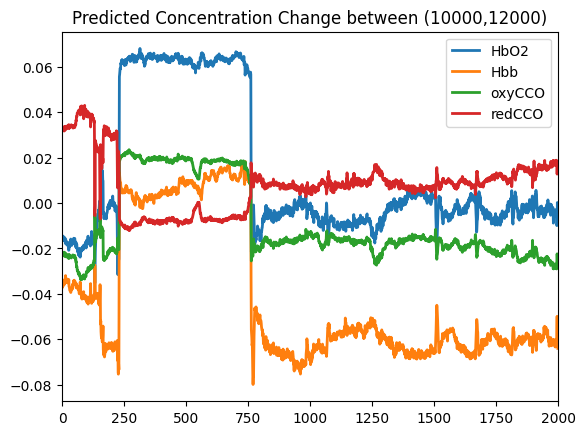

In [4]:
lcut = 10000
rcut = 12000
cut = rcut-lcut
cut_preds = preds[lcut:rcut]
cut_targets = targets[lcut:rcut]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
coef = ["HbO2", "Hbb", "oxyCCO", "redCCO"]
for i in range(4):
    plt.plot(cut_preds[:, i], color=colors[i], label=coef[i], linewidth=2)

plt.title(f"Predicted Concentration Change between ({lcut},{rcut})")
plt.xlim([0, cut])
plt.legend()

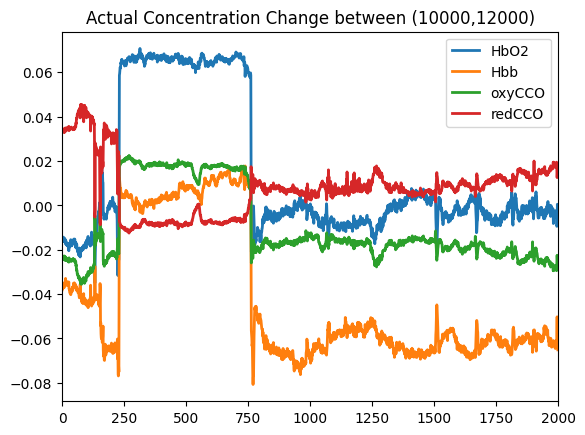

In [5]:
for i in range(4):
    plt.plot(cut_targets[:, i], color=colors[i], label=coef[i], linewidth=2)

plt.title(f"Actual Concentration Change between ({lcut},{rcut})")
plt.xlim([0, cut])
plt.legend()

Mean Square Error: 9.39904287395658e-07


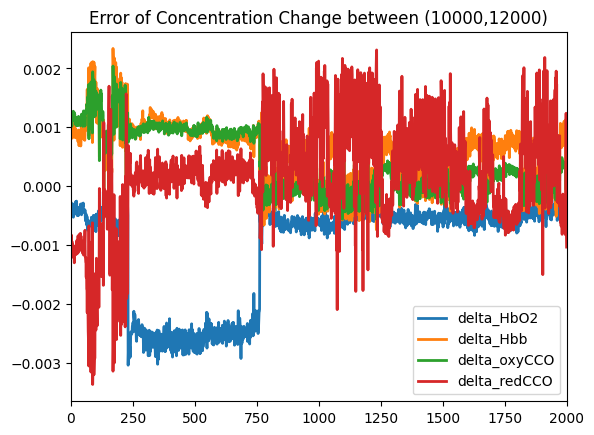

In [6]:
diff = cut_preds - cut_targets
coef_diff = ["delta_HbO2", "delta_Hbb", "delta_oxyCCO", "delta_redCCO"]
color_diff = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i in range(4):
    plt.plot(diff[:, i], color=color_diff[i], label=coef_diff[i], linewidth=2)

plt.title(f"Error of Concentration Change between ({lcut},{rcut})")
plt.xlim([0, cut])
plt.legend()

error = np.mean(np.square(diff))
print(f'Mean Square Error: {error}')

In [8]:
spectra_dataset